In [340]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import math
import json
import time
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [341]:
ratings=pd.read_csv('olist_order_reviews_dataset.csv')
products=pd.read_csv('olist_products_dataset.csv')
customers=pd.read_csv('olist_customers_dataset.csv')
orders=pd.read_csv('olist_orders_dataset.csv')
orderitems=pd.read_csv('olist_order_items_dataset.csv')
payments=pd.read_csv('olist_order_payments_dataset.csv')
category=pd.read_csv('product_category_name_translation.csv')
geolocation=pd.read_csv('olist_geolocation_dataset.csv')

In [342]:
df=pd.merge(customers, orders, on='customer_id', how='inner')
df= df.merge(ratings, on="order_id", how='inner')
df= df.merge(orderitems, on="order_id", how='inner')
df= df.merge(products, on="product_id", how='inner')
df= df.merge(payments, on="order_id", how='inner')
df= df.merge(category, on='product_category_name', how='inner')
df.shape

(115609, 37)

In [343]:
df.describe()

,customer_zip_code_prefix,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000
mean,35061.537597,4.034409,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,1.093747,2.946233,172.387379
std,29841.671732,1.385584,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,0.729849,2.781087,265.873969
min,1003.000000,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000
25%,11310.000000,4.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.870000
50%,24241.000000,5.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.050000
75%,58745.000000,5.000000,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.480000
max,99980.000000,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000


In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   order_id                       115609 non-null  object 
 6   order_status                   115609 non-null  object 
 7   order_purchase_timestamp       115609 non-null  object 
 8   order_approved_at              115595 non-null  object 
 9   order_delivered_carrier_date   114414 non-null  object 
 10  order_delivered_customer_date  113209 non-null  object 
 11  order_estimated_delivery_date  115609 non-null  object 
 12  review_id                     

In [345]:
df.isna().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             101808
review_comment_message            66703
review_creation_date                  0
review_answer_timestamp               0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0


In [346]:
df.dropna(subset= ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'], inplace=True)

In [347]:
df.drop(27352, inplace=True)
df.reset_index(inplace= True, drop= True)

In [348]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,16/5/2017 15:05,16/5/2017 15:22,23/5/2017 10:47,...,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,9/11/2017 0:50,10/11/2017 0:47,22/11/2017 1:43,...,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,9/11/2017 0:50,10/11/2017 0:47,22/11/2017 1:43,...,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,7/5/2017 20:11,8/5/2017 22:22,19/5/2017 20:16,...,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,3/2/2018 19:45,4/2/2018 22:29,19/2/2018 18:21,...,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113188,e618ce61b7a6c510ada191f657306c68,4b7f26d90bb264ade7e4281db1b739f1,13088,campinas,SP,cc9760bf7b5d5b74c4d1eb1ab6405b50,delivered,17/7/2018 13:32,18/7/2018 4:35,19/7/2018 15:00,...,1.0,267.0,24.0,7.0,13.0,1,boleto,1,37.47,arts_and_craftmanship
113189,6b47c3eea2c418b4ee03f1cc38e30519,215c346bf0164978a8725f01f7715ab4,37150,carmo do rio claro,MG,08322b6d209359f491acb1e5f89cb371,delivered,22/8/2018 20:16,24/8/2018 3:05,24/8/2018 13:57,...,5.0,6850.0,105.0,5.0,65.0,1,boleto,1,306.72,arts_and_craftmanship
113190,28738edfba72391be47d697e6e7e5770,e839774c9d31569dba47946296e58b33,11035,santos,SP,31a2886d02ad2127bfec204da2e93b66,delivered,25/7/2018 10:27,25/7/2018 10:35,25/7/2018 14:53,...,2.0,325.0,27.0,10.0,14.0,1,credit_card,1,27.20,arts_and_craftmanship
113191,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940,rolim de moura,RO,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,26/1/2017 11:09,26/1/2017 11:22,27/1/2017 14:59,...,1.0,1225.0,27.0,35.0,15.0,1,credit_card,1,209.06,security_and_services


In [349]:
def classify_cat(x):

    if x in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif x in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif x in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif x in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif x in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif x in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif x in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif x in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif x in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'

df['product_category']=df.product_category_name_english.apply(classify_cat)

In [350]:
df.product_category.value_counts()

Electronics                29568
Furniture                  28050
Entertainment              13506
Beauty & Health            13283
Home & Garden              12848
Fashion                     9723
Books & Stationery          3427
Industry & Construction     1633
Food & Drinks               1155
Name: product_category, dtype: int64

In [351]:
df.dropna(subset=['order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','product_photos_qty','order_delivered_customer_date','order_estimated_delivery_date','review_creation_date','shipping_limit_date','review_answer_timestamp','shipping_limit_date','price','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_type','payment_installments','payment_value'], inplace=True)

In [352]:
df
#try to change 20 rows into integer and execute

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,product_category_name_english,product_category
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,16/5/2017 15:05,16/5/2017 15:22,23/5/2017 10:47,...,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,office_furniture,Furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,9/11/2017 0:50,10/11/2017 0:47,22/11/2017 1:43,...,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,office_furniture,Furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,9/11/2017 0:50,10/11/2017 0:47,22/11/2017 1:43,...,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,office_furniture,Furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,7/5/2017 20:11,8/5/2017 22:22,19/5/2017 20:16,...,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,office_furniture,Furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,3/2/2018 19:45,4/2/2018 22:29,19/2/2018 18:21,...,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,office_furniture,Furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113188,e618ce61b7a6c510ada191f657306c68,4b7f26d90bb264ade7e4281db1b739f1,13088,campinas,SP,cc9760bf7b5d5b74c4d1eb1ab6405b50,delivered,17/7/2018 13:32,18/7/2018 4:35,19/7/2018 15:00,...,267.0,24.0,7.0,13.0,1,boleto,1,37.47,arts_and_craftmanship,Entertainment
113189,6b47c3eea2c418b4ee03f1cc38e30519,215c346bf0164978a8725f01f7715ab4,37150,carmo do rio claro,MG,08322b6d209359f491acb1e5f89cb371,delivered,22/8/2018 20:16,24/8/2018 3:05,24/8/2018 13:57,...,6850.0,105.0,5.0,65.0,1,boleto,1,306.72,arts_and_craftmanship,Entertainment
113190,28738edfba72391be47d697e6e7e5770,e839774c9d31569dba47946296e58b33,11035,santos,SP,31a2886d02ad2127bfec204da2e93b66,delivered,25/7/2018 10:27,25/7/2018 10:35,25/7/2018 14:53,...,325.0,27.0,10.0,14.0,1,credit_card,1,27.20,arts_and_craftmanship,Entertainment
113191,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940,rolim de moura,RO,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,26/1/2017 11:09,26/1/2017 11:22,27/1/2017 14:59,...,1225.0,27.0,35.0,15.0,1,credit_card,1,209.06,security_and_services,Electronics


In [353]:
df=df.drop(['order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','product_photos_qty','order_delivered_customer_date','order_estimated_delivery_date','review_creation_date','shipping_limit_date','review_answer_timestamp','shipping_limit_date','price','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_type','payment_installments','payment_value','product_name_lenght','product_description_lenght','review_comment_title','review_comment_message','product_category_name'], axis=1)

In [354]:
df.isna().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
review_id                        0
review_score                     0
order_item_id                    0
product_id                       0
seller_id                        0
freight_value                    0
product_category_name_english    0
product_category                 0
dtype: int64

In [355]:
df['customer_id'] = df['customer_id'].astype('str')
df['order_id'] = df['order_id'].astype('str')
df['product_id'] = df['product_id'].astype('str')

In [356]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,review_id,review_score,order_item_id,product_id,seller_id,freight_value,product_category_name_english,product_category
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,88b8b52d46df026a9d1ad2136a59b30b,4,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,21.88,office_furniture,Furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,7fc63200f12eebb5f387856afdd63db8,1,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,office_furniture,Furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,7fc63200f12eebb5f387856afdd63db8,1,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,office_furniture,Furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,251191809e37c1cffc16865947c18a4d,3,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,15.62,office_furniture,Furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,f7123bac5b91a0e2e38d8b41fd1206f4,4,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,30.59,office_furniture,Furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113188,e618ce61b7a6c510ada191f657306c68,4b7f26d90bb264ade7e4281db1b739f1,13088,campinas,SP,cc9760bf7b5d5b74c4d1eb1ab6405b50,012902a4690846e0d3e1cb3a950a1bd0,1,1,54b391a91c3b1a1e22af86434155834d,2ea0861cc19e94cad86438c984c52da4,13.68,arts_and_craftmanship,Entertainment
113189,6b47c3eea2c418b4ee03f1cc38e30519,215c346bf0164978a8725f01f7715ab4,37150,carmo do rio claro,MG,08322b6d209359f491acb1e5f89cb371,10153c6e8359f4e73f3a796cc033c96b,5,1,43506d2b6b5e0535079f88c7dc51c4de,05730013efda596306417c3b09302475,68.72,arts_and_craftmanship,Entertainment
113190,28738edfba72391be47d697e6e7e5770,e839774c9d31569dba47946296e58b33,11035,santos,SP,31a2886d02ad2127bfec204da2e93b66,4db058a0de16a06db15c4217ce42a426,5,1,3a96bcbf644a5d390107570628568026,70126eecc6aa1274392a1743866e9678,7.40,arts_and_craftmanship,Entertainment
113191,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940,rolim de moura,RO,2c4ada2e75c2ad41dd93cebb5df5f023,82ec4a1c6f0134f607033e23431ee298,4,1,6c7a0a349ad11817745e3ad58abd5c79,48162d548f5b1b11b9d29d1e01f75a61,25.77,security_and_services,Electronics


In [357]:
print('The ratings dataset has', df['review_id'].nunique(), 'unique reviews.')
print('The ratings dataset has', df['review_score'].nunique(), 'unique ratings.')
print('The unique ratings are', sorted(df['review_score'].unique()))

The ratings dataset has 94295 unique reviews.
The ratings dataset has 5 unique ratings.
The unique ratings are [1, 2, 3, 4, 5]


In [358]:
df['product_category'] = df['product_category'].astype('str')

In [359]:
matrix=df.pivot_table(index='product_category', columns='customer_id', values='review_score')

In [360]:
matrix

customer_id,00012a2ce6f8dcda20d059ce98491703,000161a058600d5901f007fab4c27140,0001fd6190edaaf884bcaf3d49edf079,0002414f95344307404f0ace7a26f1d5,000379cdec625522490c315e70c7a9fb,0004164d20a9e969af783496f3408652,000419c5494106c306a97b5635748086,00046a560d407e99b969756e0b10f282,00050bf6e01e69d5c0fd612f1bcfb69c,000598caf2ef4117407665ac33275130,...,fff89c8ed4fcf69a823c1d149e429a0b,fff906ecb75de5809be384e0f8d65e45,fff93c1da78dafaaa304ff032abc6205,fffa0238b217e18a8adeeda0669923a3,fffb97495f78be80e2759335275df2aa,fffcb937e9dd47a13f05ecb8290f4d3e,fffecc9f79fd8c764f843e9951b11341,fffeda5b6d849fbd39689bb92087f431,ffff42319e9b2d713724ae527742af25,ffffa3172527f765de70084a7e53aae8
product_category,,,,,,,,,,,,,,,,,,,,,
Beauty & Health,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
Books & Stationery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
Electronics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
Entertainment,1.0,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fashion,NaN,NaN,5.0,5.0,NaN,NaN,1.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Food & Drinks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Furniture,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,3.0,NaN,5.0,5.0
Home & Garden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry & Construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [361]:
matrix_norm=matrix.subtract(matrix.mean(axis=1), axis=0)
matrix_norm

customer_id,00012a2ce6f8dcda20d059ce98491703,000161a058600d5901f007fab4c27140,0001fd6190edaaf884bcaf3d49edf079,0002414f95344307404f0ace7a26f1d5,000379cdec625522490c315e70c7a9fb,0004164d20a9e969af783496f3408652,000419c5494106c306a97b5635748086,00046a560d407e99b969756e0b10f282,00050bf6e01e69d5c0fd612f1bcfb69c,000598caf2ef4117407665ac33275130,...,fff89c8ed4fcf69a823c1d149e429a0b,fff906ecb75de5809be384e0f8d65e45,fff93c1da78dafaaa304ff032abc6205,fffa0238b217e18a8adeeda0669923a3,fffb97495f78be80e2759335275df2aa,fffcb937e9dd47a13f05ecb8290f4d3e,fffecc9f79fd8c764f843e9951b11341,fffeda5b6d849fbd39689bb92087f431,ffff42319e9b2d713724ae527742af25,ffffa3172527f765de70084a7e53aae8
product_category,,,,,,,,,,,,,,,,,,,,,
Beauty & Health,NaN,-0.237607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.762393,NaN,NaN,NaN,NaN,NaN,NaN
Books & Stationery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.653266,0.653266,NaN,NaN,0.653266,NaN,NaN,NaN,NaN
Electronics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.110222,NaN,NaN,NaN,NaN,NaN,NaN,-0.110222,NaN,NaN
Entertainment,-3.227411,NaN,NaN,NaN,NaN,-3.227411,NaN,0.772589,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fashion,NaN,NaN,0.816858,0.816858,NaN,NaN,-3.183142,NaN,0.816858,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Food & Drinks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Furniture,NaN,NaN,NaN,NaN,-0.035672,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.964328,NaN,-1.035672,NaN,0.964328,0.964328
Home & Garden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.785912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry & Construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [362]:
item_similarity=matrix_norm.T.corr()
item_similarity

product_category,Beauty & Health,Books & Stationery,Electronics,Entertainment,Fashion,Food & Drinks,Furniture,Home & Garden,Industry & Construction
product_category,,,,,,,,,
Beauty & Health,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
Books & Stationery,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
Electronics,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Entertainment,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
Fashion,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
Food & Drinks,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN
Furniture,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
Home & Garden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Industry & Construction,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0


In [363]:
item_similarity_cosine=cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

array([[1.00000000e+00, 4.37289065e-03, 1.28555422e-03, 5.60179773e-03,
        4.27675357e-04, 2.63296978e-03, 2.13099430e-03, 2.50389533e-03,
        1.05860206e-04],
       [4.37289065e-03, 1.00000000e+00, 1.33984967e-04, 6.61912692e-03,
        1.65293359e-03, 0.00000000e+00, 5.34742010e-04, 3.78835147e-03,
        0.00000000e+00],
       [1.28555422e-03, 1.33984967e-04, 1.00000000e+00, 3.50054274e-03,
        4.58757793e-03, 1.68807126e-03, 4.08345403e-03, 4.48207316e-03,
        3.19498260e-03],
       [5.60179773e-03, 6.61912692e-03, 3.50054274e-03, 1.00000000e+00,
        6.88780602e-03, 1.57165217e-03, 3.74218402e-03, 3.48056755e-03,
        2.16602366e-04],
       [4.27675357e-04, 1.65293359e-03, 4.58757793e-03, 6.88780602e-03,
        1.00000000e+00, 0.00000000e+00, 9.58453930e-03, 1.97336552e-03,
        3.92808272e-04],
       [2.63296978e-03, 0.00000000e+00, 1.68807126e-03, 1.57165217e-03,
        0.00000000e+00, 1.00000000e+00, 9.38386072e-05, 4.89936260e-04,
        0.0

In [364]:
picked_userID='fff906ecb75de5809be384e0f8d65e45'
picked_category='Fashion'
picked_userID_bought=pd.DataFrame(matrix_norm[picked_userID].dropna(axis=0, how='all')\
                                 .sort_values(ascending=False)).reset_index().rename(columns={1:'rating'})
picked_userID_bought

,product_category,fff906ecb75de5809be384e0f8d65e45
0,Books & Stationery,0.653266


In [365]:
#test
#n=10
#item_similarity_threshold=0.3
#similar_items=item_similarity[item_similarity[picked_userID]>item_similarity_threshold][picked_userID].sort_values(ascending=False)[:n]
#print(f'The similar users for user {picked_userID} are', similar_users)

In [366]:
df_test=df.iloc[0:1000]

In [367]:
df_test

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,review_id,review_score,order_item_id,product_id,seller_id,freight_value,product_category_name_english,product_category
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,88b8b52d46df026a9d1ad2136a59b30b,4,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,21.88,office_furniture,Furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,7fc63200f12eebb5f387856afdd63db8,1,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,office_furniture,Furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,7fc63200f12eebb5f387856afdd63db8,1,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,office_furniture,Furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,251191809e37c1cffc16865947c18a4d,3,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,15.62,office_furniture,Furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,f7123bac5b91a0e2e38d8b41fd1206f4,4,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,30.59,office_furniture,Furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,176e4214bb992cb6ecb6d426f39db3b1,6fc0d32375bbbe60599f0817445e4f62,36010,juiz de fora,MG,9c4dfa7a4f01d5042e9363edd0c7c7b9,21e73521b7096cdf5f8f10ddb39c2f0b,5,1,22594ba8fd9a72ad95d352929c821560,7c67e1448b00f6e969d365cea6b010ab,28.89,office_furniture,Furniture
996,5eedff30a379fbcc0851653d18295723,2fbac141bcb7101d19fab96ef64100b3,6807,embu das artes,SP,8cb407154874301be08656a7fb09d9d9,7f6dd67b7b7df2504e245e9a6375c78b,3,1,22594ba8fd9a72ad95d352929c821560,7c67e1448b00f6e969d365cea6b010ab,17.53,office_furniture,Furniture
997,5eedff30a379fbcc0851653d18295723,2fbac141bcb7101d19fab96ef64100b3,6807,embu das artes,SP,8cb407154874301be08656a7fb09d9d9,7f6dd67b7b7df2504e245e9a6375c78b,3,1,22594ba8fd9a72ad95d352929c821560,7c67e1448b00f6e969d365cea6b010ab,17.53,office_furniture,Furniture
998,b4ec511dd283ea2371a1bc337d1c62b2,bf2c9b13ac8de1a14454fe0f1379cfb5,63010,juazeiro do norte,CE,44e4e6de79505211800da6a7b4489511,6ad653da3f2052892e5808a468e2e89b,4,1,22594ba8fd9a72ad95d352929c821560,7c67e1448b00f6e969d365cea6b010ab,49.72,office_furniture,Furniture


In [368]:
df_test.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
review_id                         object
review_score                       int64
order_item_id                      int64
product_id                        object
seller_id                         object
freight_value                    float64
product_category_name_english     object
product_category                  object
dtype: object

In [369]:
df_test.describe()['review_score'].T

count    1000.000000
mean        3.532000
std         1.497738
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: review_score, dtype: float64

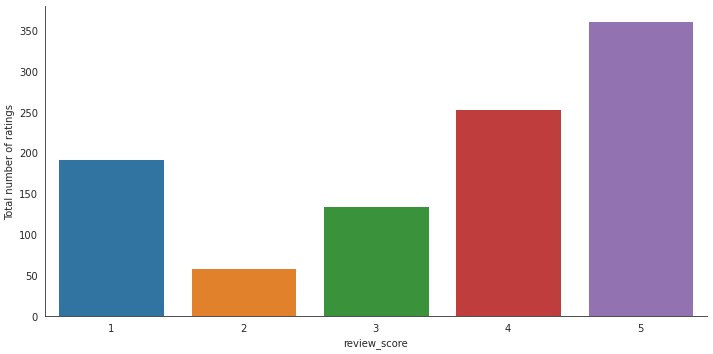

In [370]:
with sns.axes_style('white'):
    g = sns.factorplot("review_score", data=df_test, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [371]:
no_of_rated_products_per_user = df_test.groupby(by='customer_id')['review_score'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

customer_id
0c792d32a3251b4f69dae8646dfbedbc    8
69cb766f106988cd621b3b6c67221826    8
368f207cdc8f5c93a2b2a5d4cce96ba8    7
dcdd2033f19ef7bcacdf2e683c8f2e65    7
b7c889215de76857c7967c1011125d2d    6
Name: review_score, dtype: int64

In [372]:
new_df=df_test.groupby("product_id").filter(lambda x:x['review_score'].count() >=3)

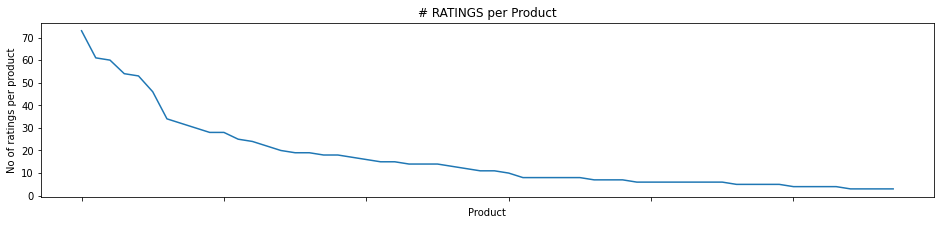

In [373]:
no_of_ratings_per_product = new_df.groupby(by='product_id')['review_score'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(0.2))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [374]:
#average rating of product
new_df.groupby('product_id')['review_score'].mean().head()

product_id
02ce0c74e59d6cf6bc9026601414a9c4    5.000000
02ce467092b184e71d3967d29110adc1    3.350000
0364c36f8e845e4d309c0a3accc04b1c    3.875000
07f381c65e8e66460c07781b9b1b8834    3.647059
143bc7fcaf6929ef5979e58abf39d4ed    4.000000
Name: review_score, dtype: float64

In [375]:
new_df.groupby('product_id')['review_score'].mean().sort_values(ascending=False).head()

product_id
02ce0c74e59d6cf6bc9026601414a9c4    5.000000
6f842ad54a86bf94d9254744d910ec56    5.000000
475e8a9ddbebf13af503d1c7eccadb1a    4.789474
b03f486273ee4263286c00383ef34f37    4.750000
3eef0cb94ba82de806bb30ab743c7655    4.666667
Name: review_score, dtype: float64

In [376]:
#total no. of rating for products
new_df.groupby('product_id')['review_score'].count().sort_values(ascending=False).head()

product_id
8ed094bfe076c568f6bb10feada3f75d    73
a9516a079e37a9c9c36b9b78b10169e8    61
aba86c093ccdbac75b09111d57e50004    60
b114bf337c0626166abe574eee9e3f32    54
2a5806f10d0f00e5ad032dd2e3c8806e    53
Name: review_score, dtype: int64

In [377]:
ratings_mean_count = pd.DataFrame(new_df.groupby('product_id')['review_score'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('product_id')['review_score'].count())
ratings_mean_count.head()

,review_score,rating_counts
product_id,,
02ce0c74e59d6cf6bc9026601414a9c4,5.000000,3
02ce467092b184e71d3967d29110adc1,3.350000,20
0364c36f8e845e4d309c0a3accc04b1c,3.875000,16
07f381c65e8e66460c07781b9b1b8834,3.647059,17
143bc7fcaf6929ef5979e58abf39d4ed,4.000000,4


In [378]:
ratings_mean_count['rating_counts'].max()

73

In [379]:
#plt.figure(figsize=(8,6))
#plt.rcParams['patch.force_edgecolor'] = True
#ratings_mean_count['rating_counts'].hist(bins=50)

<AxesSubplot:xlabel='product_id'>

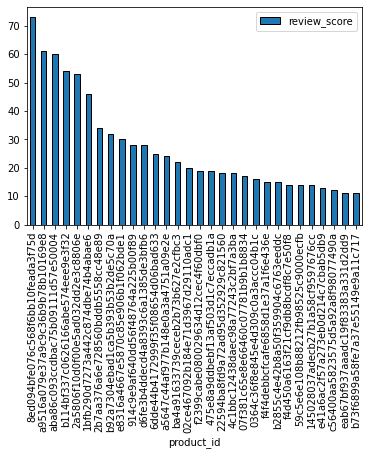

In [380]:
popular_products = pd.DataFrame(new_df.groupby('product_id')['review_score'].count())
most_popular = popular_products.sort_values('review_score', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [381]:
!pip install scikit-surprise

In [382]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [383]:
#reader = Reader(rating_scale=(1,5))
#data = Dataset.load_from_df(new_df,reader)

In [ ]:
new_df1=df.head(20000)
ratings_matrix = new_df1.pivot_table(values='review_score', index='customer_id', columns='product_id', fill_value=0)
ratings_matrix

In [398]:
ratings_matrix.shape

(736, 79)

In [399]:
X = ratings_matrix.T
X

customer_id,0058ebe2dc136d918dd001968cfa5903,014e22ebe12fcc0f03d5f3ed1d15f86f,02841fd8efadbaf1b2e99e29822ed8e2,03787ef7555b94c1a63477e7e7441881,038aa59fda83ef09082edd0718cd97ff,039e022bbbf82354bd7ea61f3d2d8339,03f7c28100418ce57927a01d62a6cdf3,040a6b33a803ef269d0bf0c285cb2390,042b53f9e609289d8f6fcbd59b4acf63,04932ff700030fe6c723a32ed80bc2ad,...,fd06ce41eadcf13f9037d2ae8ef8b744,fd3a0b1bd209f0e7d420c9c3d1127613,fd709023690c423c8e83bab1d36cd8b1,fe886eb588842ffebbe5af67cb142a9b,febf5be282b3d17142f2d183967aae3f,ff726e16b7e716c6781a22bedc7381ca,ff82e32ae70caa86b2e3232c9474fce4,ff8d16a27756dee8602746a20cf0cf8a,ffabac359c29ee1a640dcd57f275a2f7,ffde64401f7cb62d2e8696d9467c781d
product_id,,,,,,,,,,,,,,,,,,,,,
02ce0c74e59d6cf6bc9026601414a9c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02ce467092b184e71d3967d29110adc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0364c36f8e845e4d309c0a3accc04b1c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07f381c65e8e66460c07781b9b1b8834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0c9452f6a812935c0615faee8bf8646b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f4d450a6163f21cf9db8bcdf8c7e50f8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f4f4debbcfcafe6858d1e37a1f6e436e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f80214fd7d681d1dcf12b3acaf4f0da7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [400]:
X.shape

(79, 736)

In [388]:
X1 = X

In [389]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(58, 10)

In [390]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(58, 58)

In [391]:
X.index[2]

'0364c36f8e845e4d309c0a3accc04b1c'

In [392]:
i = "0364c36f8e845e4d309c0a3accc04b1c"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

2

In [393]:
#correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(58,)

In [395]:
Recommend = list(X.index[correlation_product_ID > 0.5])

#removes the item already bought by the customer
Recommend.remove(i) 

#top 10 item recommendations to customers who bought item 0364c36f8e845e4d309c0a3accc04b1c
Recommend[0:10]

['02ce0c74e59d6cf6bc9026601414a9c4',
 '02ce467092b184e71d3967d29110adc1',
 '07f381c65e8e66460c07781b9b1b8834',
 '1878fcfa202ce65b4bfaa9d16250ee86',
 '1fb2c1a0d7f863e0644077cb5d8f80df',
 '22594ba8fd9a72ad95d352929c821560',
 '2b7aa376a6e728560bddb5558cc48e89',
 '30de9bc2bc110c6a584cacba9c17d88a',
 '3bf87d2001b8176e6a3ad804b80774b4',
 '59c5e6e108b88212fb98525c9000ecfb']